This notebook solves numerically the system of equations (13) and (14) in Result 2.3, for a generic binary mixture. We simply iterate over the equations (13-14) until the variables converge and a solution is found. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.integrate import quad as quad
import pandas as pd

In [16]:
import quadpy

scheme = quadpy.e2r2.get_good_scheme(7)

def Gaussian(x):
    return np.exp(-.5*x**2-.5*np.log(2*np.pi))

In [17]:

ϕ=np.tanh


In [18]:
d=500        #dimension


μ=np.ones(d)  #cluster centroid


# For example, we take the covariances to be i.i.d Wishart-Laguerre matrices
seed1=np.random.RandomState(4)
seed2=np.random.RandomState(456)
F1=seed1.randn(d,700)/np.sqrt(700)  
F2=seed2.randn(d,600)/np.sqrt(600)

Σp=F1@F1.T*.1
Σm=F2@F2.T*.1

In [29]:
def update_overlaps(qhat,mhat,Vhat,qhatp,qhatm,Vhatp,Vhatm,σ_e,λ):
    S=(λ+Vhat)*np.eye(d)+Vhatp*Σp+Vhatm*Σm
    
    D,U=np.linalg.eigh(S)
    
    D=1/D
    
    Sp=U.T@Σp@U
    Sm=U.T@Σm@U
    UmU=U.T@μ.reshape(-1,1)@μ.reshape(1,-1)@U
    
    #update q
    q=np.mean(D**2*np.diag(qhat*np.eye(d)+qhatp*Sp+qhatm*Sm+mhat**2*UmU))
    
    #update m
    m=mhat*np.mean(D*np.diag(UmU))
    
    #update V
    V=np.mean(D)
    
    #update q1,q2
    qp=np.mean(D*np.diag(Sp@np.diag(D)@(qhat*np.eye(d)+qhatp*Sp+qhatm*Sm+mhat**2*UmU)))
    qm=np.mean(D*np.diag(Sm@np.diag(D)@(qhat*np.eye(d)+qhatp*Sp+qhatm*Sm+mhat**2*UmU)))
               
    #update V2,V2
    Vp=np.mean(D*np.diag(Sp))
    Vm=np.mean(D*np.diag(Sm))
    
    
    return q,m,V, qp,Vp,qm,Vm
    

In [30]:
def Moreau_p(X,s,q,m,V,qp,Vp,ξ1,ξ2,σ_e,λ):
    σ=np.sqrt(.5*(np.trace(Σp)/d)+.5*(np.trace(Σm)/d))
    b=σ**2*np.sqrt(1-σ_e**2)/(σ**2*(1-σ_e**2)+σ_e**2)
    x,y=X
    c=np.sqrt(1-σ_e**2)
    termx=(x-np.sqrt(q)*σ_e*ξ1)**2/σ_e**2/V
    termy=(y-np.sqrt(qp)*ξ2-m)**2/Vp
    term_activ=q*ϕ(c*y+x)**2-2*ϕ(c*y+x)*((1-c*b)*y-b*x)
    return termx+termy+term_activ

def Moreau_m(X,s,q,m,V,qm,Vm,ξ1,ξ2,σ_e,λ):
    σ=np.sqrt(.5*(np.trace(Σp)/d)+.5*(np.trace(Σm)/d))
    b=σ**2*np.sqrt(1-σ_e**2)/(σ**2*(1-σ_e**2)+σ_e**2)
    x,y=X
    c=np.sqrt(1-σ_e**2)
    termx=(x-np.sqrt(q)*σ_e*ξ1)**2/σ_e**2/V
    termy=(y-np.sqrt(qm)*ξ2+m)**2/Vm
    term_activ=q*ϕ(c*y+x)**2-2*ϕ(c*y+x)*((1-c*b)*y-b*x)
    return termx+termy+term_activ

def prox_p(s,q,m,V,qp,Vp,ξ1,ξ2,σ_e,λ):
    res=[]
    for i in range(len(ξ1)):
        res.append(optimize.minimize(lambda x: Moreau_p(x,s,q,m,V,qp,Vp,ξ1[i],ξ2[i],σ_e,λ),[.01,.01]).x)
    res=np.array(res)
    return res[:,0], res[:,1]

def prox_m(s,q,m,V,qm,Vm,ξ1,ξ2,σ_e,λ):
    res=[]
    for i in range(len(ξ1)):
        res.append(optimize.minimize(lambda x: Moreau_m(x,s,q,m,V,qm,Vm,ξ1[i],ξ2[i],σ_e,λ),[.01,.01]).x)
    res=np.array(res)
    return res[:,0], res[:,1]
    
    
    

In [31]:
def int_mhat(ξ,s,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    if s>0:
        _,proxy=prox_p(s,q,m,V,qp,Vp,ξ[0],ξ[1],σ_e,λ)
        return (proxy-np.sqrt(qp)*ξ[1]-m)/Vp
    else:
        _,proxy=prox_m(s,q,m,V,qm,Vm,ξ[0],ξ[1],σ_e,λ)
        return (proxy-np.sqrt(qm)*ξ[1]+m)/Vm

def int_Vhat(ξ,s,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    if s>0:
        proxx,proxy=prox_p(s,q,m,V,qp,Vp,ξ[0],ξ[1],σ_e,λ)
    else:
        proxx,proxy=prox_m(s,q,m,V,qm,Vm,ξ[0],ξ[1],σ_e,λ)
    term1=ξ[0]*(proxx-σ_e*np.sqrt(q)*ξ[0])/σ_e/np.sqrt(q)/V
    
    term3=-ϕ(np.sqrt(1-σ_e**2)*proxy+proxx)**2
    return term1+term3

def int_qhat(ξ,s,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    if s>0:
        proxx,proxy=prox_p(s,q,m,V,qp,Vp,ξ[0],ξ[1],σ_e,λ)
    else:
        proxx,proxy=prox_m(s,q,m,V,qm,Vm,ξ[0],ξ[1],σ_e,λ)
    term1=(proxx-σ_e*np.sqrt(q)*ξ[0])**2/σ_e**2/V**2
    return term1

def int_qhatp(ξ,s,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    _,proxy=prox_p(s,q,m,V,qp,Vp,ξ[0],ξ[1],σ_e,λ)
    return (proxy-np.sqrt(qp)*ξ[1]-m)**2/Vp**2

def int_qhatm(ξ,s,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    _,proxy=prox_m(s,q,m,V,qm,Vm,ξ[0],ξ[1],σ_e,λ)
    return (proxy-np.sqrt(qm)*ξ[1]+m)**2/Vm**2

def int_Vhatp(ξ,s,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    _,proxy=prox_p(s,q,m,V,qp,Vp,ξ[0],ξ[1],σ_e,λ)
    return ξ[1]*(proxy-np.sqrt(qp)*ξ[1]-m)/np.sqrt(qp)/Vp

def int_Vhatm(ξ,s,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    _,proxy=prox_m(s,q,m,V,qm,Vm,ξ[0],ξ[1],σ_e,λ)
    return ξ[1]*(proxy-np.sqrt(qm)*ξ[1]+m)/np.sqrt(qm)/Vm


def update_mhat(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    int_mhat_plus=scheme.integrate(lambda x: int_mhat(np.sqrt(2)*x,1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    int_mhat_minus=scheme.integrate(lambda x: int_mhat(np.sqrt(2)*x,-1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    mhat=α*.5*(int_mhat_plus-int_mhat_minus)
    return mhat

def update_Vhat(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    int_Vhat_plus=scheme.integrate(lambda x: int_Vhat(np.sqrt(2)*x,1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    int_Vhat_minus=scheme.integrate(lambda x: int_Vhat(np.sqrt(2)*x,-1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    Vhat=-α*.5*(int_Vhat_plus+int_Vhat_minus)
    return Vhat

def update_qhat(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    int_qhat_plus=scheme.integrate(lambda x: int_qhat(np.sqrt(2)*x,1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    int_qhat_minus=scheme.integrate(lambda x: int_qhat(np.sqrt(2)*x,-1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    qhat=α*.5*(int_qhat_plus+int_qhat_minus)
    return qhat


def update_qhatp(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    qhatp=scheme.integrate(lambda x: int_qhatp(np.sqrt(2)*x,1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    qhatp*=α*.5
    return qhatp

def update_qhatm(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    qhatm=scheme.integrate(lambda x: int_qhatm(np.sqrt(2)*x,-1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    qhatm*=α*.5
    return qhatm

def update_Vhatp(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    Vhatp=scheme.integrate(lambda x: int_Vhatp(np.sqrt(2)*x,1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    Vhatp*=-α*.5
    return Vhatp

def update_Vhatm(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    Vhatm=scheme.integrate(lambda x: int_Vhatm(np.sqrt(2)*x,-1,q,m,V,qp,Vp,qm,Vm,σ_e,λ))/np.pi#np.sqrt(np.pi)
    Vhatm*=-α*.5
    return Vhatm

def update_hat_overlaps(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ):
    Vhat=update_Vhat(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ)
    qhat=update_qhat(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ)
    mhat=update_mhat(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ)
    qhatp=update_qhatp(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ)
    qhatm=update_qhatm(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ)
    Vhatp=update_Vhatp(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ)
    Vhatm=update_Vhatm(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ)
    return qhat,mhat,Vhat, qhatp,Vhatp,qhatm,Vhatm
    

In [32]:
def mse(q,m,V,qp,Vp,qm,Vm,σ_e):
    c=np.sqrt(1-σ_e**2)
    σeff=np.sqrt(.5*(np.trace(Σp)/d)+.5*(np.trace(Σm)/d))
    b=σeff**2*np.sqrt(1-σ_e**2)/(σeff**2*(1-σ_e**2)+σ_e**2)
    
    
    term1p=quad(lambda x: ϕ(c*m+np.sqrt(q*σ_e**2+c**2*qp)*x)**2*Gaussian(x),-10,10)[0]
    term1m=quad(lambda x: ϕ(-c*m+np.sqrt(q*σ_e**2+c**2*qm)*x)**2*Gaussian(x),-10,10)[0]
    
    
    
    term2p=scheme.integrate(lambda x: ϕ(c*m+c*np.sqrt(2*qp)*x[0]+np.sqrt(2*q*σ_e**2)*x[1]
                                       )*((1-b*c)*(m+np.sqrt(2*qp)*x[0])-b*np.sqrt(q*σ_e**2)*x[1]))/np.pi
    term2m=scheme.integrate(lambda x: ϕ(-c*m+c*np.sqrt(2*qm)*x[0]+np.sqrt(2*q*σ_e**2)*x[1]
                                       )*((1-b*c)*(-m+np.sqrt(2*qm)*x[0])-b*np.sqrt(2*q*σ_e**2)*x[1]))/np.pi
    
    
    return q/2*(term1p+term1m)-(term2p+term2m)

In [33]:
damping=0.7           

def damp(new, old):
        return (1-damping) * new + damping * old

In [34]:


def iterate(α,σ_e,λ=.1,max_iter=10000,tol=1e-4,verbose=True,init=[.8, .8,.1,.8,.1,.8,.1]):
    last_flip=None
    q,m,V,qp,Vp,qm,Vm=init
    qhat,mhat,Vhat,qhatp,Vhatp,qhatm,Vhatm=0,0,0,0,0,0,0
    for i in range(max_iter):
        qhat,mhat,Vhat,qhatp,Vhatp,qhatm,Vhatm=update_hat_overlaps(α,q,m,V,qp,Vp,qm,Vm,σ_e,λ)
        q_tmp,m_tmp,V_tmp,qp_tmp,Vp_tmp,qm_tmp,Vm_tmp=update_overlaps(qhat,mhat,Vhat,qhatp,qhatm,Vhatp,Vhatm,σ_e,λ)
        if max([np.abs(q_tmp-q),np.abs(m_tmp-m),np.abs(V_tmp-V),np.abs(qp_tmp-qp)
              ,np.abs(Vp_tmp-Vp),np.abs(qm_tmp-qm),np.abs(Vm_tmp-Vm)])<tol:
            if verbose:
                print("convcerged after {} steps".format(i))
            return q,m,V,qp,Vp,qm,Vm,qhat,mhat,Vhat,qhatp,Vhatp,qhatm,Vhatm
        
        q=damp(q_tmp,q)
        m=damp(m_tmp,m)
        V=damp(V_tmp,V)
        qp=damp(qp_tmp,qp)
        qm=damp(qm_tmp,qm)
        Vp=damp(Vp_tmp,Vp)
        Vm=damp(Vm_tmp,Vm)
       
        
        if verbose:
            print( "q{} m{} V{} qp{} qm{} Vp{} Vm {} qhat{} mhat{} Vhat{} qhatp{} qhatm{} Vhatp{} Vhatm{}".
                  format('%.4f' %q,'%.4f' %m,'%.4f' %V,'%.4f' %qp,'%.4f' %qm,
                         '%.4f' %Vp,'%.4f' %Vm,'%.4f' %qhat,'%.4f' %mhat,'%.4f' %Vhat
                        ,'%.4f' %qhatp,'%.4f' %qhatm,'%.4f' %Vhatp,'%.4f' %Vhatm))
        
    print(α, "Not converged")
    

    return  q,m,V,qp,Vp,qm,Vm,qhat,mhat,Vhat,qhatp,Vhatp,qhatm,Vhatm
        
        
        

In [43]:
def get_curves(sig_list,λ=1e-3,α=2,verbose=True):
    results={"q":[], "m":[], "V":[],
             "qp":[], "Vp":[], "qm":[],"Vm":[],
             "mse":[], "angle":[], "sigma_e":[],"alpha":[],"lambda":[]}

    
    init=[.8, .8,.1,.8,.1,.8,.1]
    for σ_e in sig_list:
        q,m,V,qp,Vp,qm,Vm,_,_,_,_,_,_,_=iterate(α=α,σ_e=σ_e,λ=λ,verbose=True,init=init)
        init=[q,m,V,qp,Vp,qm,Vm]
        angle=m/np.sqrt(q)
        error=mse(q,m,V,qp,Vp,qm,Vm,σ_e)


        results["q"].append(q)                           #squared weight norm
        results["m"].append(m)                           #weight/centroid overlap
        results["V"].append(V)
        results["qp"].append(qp)
        results["Vp"].append(Vp)
        results["qm"].append(qm)
        results["Vm"].append(Vm)
        results["mse"].append(error)                      #denoising test MSE
        results["angle"].append(angle)                    #cosine similarity
        results["sigma_e"].append(σ_e)                    #noise level \sqrt{\Delta}
        results["lambda"].append(λ)                       #l2 regularization
        results["alpha"].append(α)                        #sample complexity


    res=pd.DataFrame.from_dict(results)
    σeff=np.sqrt(.5*(np.trace(Σp)/d)+.5*(np.trace(Σm)/d))
    res["b"]=σeff**2*np.sqrt(1-res["sigma_e"]**2)/(σeff**2*(1-res["sigma_e"]**2)+res["sigma_e"]**2)   #skip connection
    return res





In [44]:
α=1
λ=1e-1

In [45]:
sig_list=np.linspace(0.02,.95,15)
res=get_curves(np.flip(sig_list),α=α,λ=λ)

q0.8738 m0.6779 V0.4263 qp0.5930 qm0.5936 Vp0.1062 Vm 0.1064 qhat0.5872 mhat0.3308 Vhat0.7816 qhatp0.2142 qhatm0.2142 Vhatp-0.1944 Vhatm-0.1944
q0.8882 m0.6110 V0.6938 qp0.4446 qm0.4458 Vp0.1147 Vm 0.1151 qhat0.3675 mhat0.3450 Vhat0.7067 qhatp0.2058 qhatm0.2059 Vhatp-0.2342 Vhatm-0.2342
q0.8830 m0.5804 V0.9219 qp0.3395 qm0.3413 Vp0.1250 Vm 0.1257 qhat0.2473 mhat0.3500 Vhat0.6413 qhatp0.1934 qhatm0.1935 Vhatp-0.2601 Vhatm-0.2600
q0.8806 m0.5768 V1.1151 qp0.2664 qm0.2687 Vp0.1359 Vm 0.1369 qhat0.1843 mhat0.3630 Vhat0.5966 qhatp0.1852 qhatm0.1854 Vhatp-0.2800 Vhatm-0.2799
q0.8909 m0.5936 V1.2739 qp0.2167 qm0.2195 Vp0.1462 Vm 0.1473 qhat0.1497 mhat0.3847 Vhat0.5691 qhatp0.1821 qhatm0.1824 Vhatp-0.2935 Vhatm-0.2933
q0.9154 m0.6240 V1.3975 qp0.1839 qm0.1872 Vp0.1547 Vm 0.1560 qhat0.1309 mhat0.4122 Vhat0.5554 qhatp0.1835 qhatm0.1839 Vhatp-0.2996 Vhatm-0.2994
q0.9498 m0.6612 V1.4869 qp0.1628 qm0.1666 Vp0.1610 Vm 0.1624 qhat0.1214 mhat0.4411 Vhat0.5520 qhatp0.1881 qhatm0.1885 Vhatp-0.2990 Vhatm

q1.2025 m0.9327 V1.4367 qp0.1287 qm0.1350 Vp0.1474 Vm 0.1486 qhat0.1083 mhat0.6633 Vhat0.6591 qhatp0.2507 qhatm0.2509 Vhatp-0.2600 Vhatm-0.2594
q1.2047 m0.9347 V1.4301 qp0.1288 qm0.1352 Vp0.1467 Vm 0.1479 qhat0.1091 mhat0.6640 Vhat0.6602 qhatp0.2511 qhatm0.2513 Vhatp-0.2593 Vhatm-0.2587
q1.2060 m0.9359 V1.4249 qp0.1289 qm0.1352 Vp0.1461 Vm 0.1473 qhat0.1097 mhat0.6643 Vhat0.6610 qhatp0.2513 qhatm0.2515 Vhatp-0.2589 Vhatm-0.2583
q1.2068 m0.9366 V1.4210 qp0.1289 qm0.1353 Vp0.1457 Vm 0.1469 qhat0.1101 mhat0.6644 Vhat0.6615 qhatp0.2514 qhatm0.2516 Vhatp-0.2586 Vhatm-0.2580
q1.2071 m0.9370 V1.4181 qp0.1289 qm0.1353 Vp0.1454 Vm 0.1466 qhat0.1104 mhat0.6644 Vhat0.6618 qhatp0.2514 qhatm0.2516 Vhatp-0.2585 Vhatm-0.2579
q1.2073 m0.9372 V1.4159 qp0.1289 qm0.1353 Vp0.1452 Vm 0.1463 qhat0.1106 mhat0.6644 Vhat0.6619 qhatp0.2514 qhatm0.2516 Vhatp-0.2584 Vhatm-0.2578
q1.2074 m0.9372 V1.4143 qp0.1289 qm0.1352 Vp0.1450 Vm 0.1462 qhat0.1108 mhat0.6644 Vhat0.6621 qhatp0.2514 qhatm0.2516 Vhatp-0.2584 Vhatm

q1.1897 m0.9778 V1.4242 qp0.1263 qm0.1330 Vp0.1457 Vm 0.1468 qhat0.0606 mhat0.6865 Vhat0.6504 qhatp0.2544 qhatm0.2543 Vhatp-0.2345 Vhatm-0.2347
q1.1897 m0.9778 V1.4241 qp0.1263 qm0.1330 Vp0.1457 Vm 0.1468 qhat0.0606 mhat0.6865 Vhat0.6504 qhatp0.2544 qhatm0.2543 Vhatp-0.2345 Vhatm-0.2347
q1.1897 m0.9778 V1.4241 qp0.1263 qm0.1330 Vp0.1457 Vm 0.1468 qhat0.0606 mhat0.6865 Vhat0.6504 qhatp0.2544 qhatm0.2543 Vhatp-0.2344 Vhatm-0.2347
convcerged after 21 steps
q1.1708 m0.9734 V1.4330 qp0.1243 qm0.1309 Vp0.1465 Vm 0.1477 qhat0.0437 mhat0.6623 Vhat0.6338 qhatp0.2357 qhatm0.2356 Vhatp-0.2240 Vhatm-0.2241
q1.1596 m0.9715 V1.4398 qp0.1231 qm0.1297 Vp0.1472 Vm 0.1484 qhat0.0429 mhat0.6642 Vhat0.6332 qhatp0.2368 qhatm0.2367 Vhatp-0.2250 Vhatm-0.2251
q1.1531 m0.9709 V1.4447 qp0.1224 qm0.1289 Vp0.1477 Vm 0.1489 qhat0.0424 mhat0.6657 Vhat0.6330 qhatp0.2377 qhatm0.2375 Vhatp-0.2253 Vhatm-0.2255
q1.1493 m0.9709 V1.4481 qp0.1220 qm0.1285 Vp0.1481 Vm 0.1492 qhat0.0421 mhat0.6668 Vhat0.6331 qhatp0.2383 qhat

q0.8834 m0.8667 V1.5953 qp0.0938 qm0.0990 Vp0.1631 Vm 0.1643 qhat0.0149 mhat0.5069 Vhat0.5519 qhatp0.1395 qhatm0.1394 Vhatp-0.2017 Vhatm-0.2017
q0.8676 m0.8594 V1.6131 qp0.0922 qm0.0973 Vp0.1650 Vm 0.1662 qhat0.0142 mhat0.5089 Vhat0.5466 qhatp0.1404 qhatm0.1403 Vhatp-0.2054 Vhatm-0.2054
q0.8598 m0.8561 V1.6279 qp0.0914 qm0.0965 Vp0.1665 Vm 0.1678 qhat0.0139 mhat0.5102 Vhat0.5441 qhatp0.1409 qhatm0.1409 Vhatp-0.2072 Vhatm-0.2072
q0.8561 m0.8547 V1.6393 qp0.0911 qm0.0961 Vp0.1677 Vm 0.1690 qhat0.0137 mhat0.5111 Vhat0.5430 qhatp0.1413 qhatm0.1413 Vhatp-0.2080 Vhatm-0.2080
q0.8544 m0.8543 V1.6477 qp0.0909 qm0.0959 Vp0.1686 Vm 0.1699 qhat0.0135 mhat0.5116 Vhat0.5426 qhatp0.1416 qhatm0.1415 Vhatp-0.2083 Vhatm-0.2083
q0.8536 m0.8542 V1.6536 qp0.0909 qm0.0959 Vp0.1693 Vm 0.1706 qhat0.0135 mhat0.5120 Vhat0.5425 qhatp0.1418 qhatm0.1417 Vhatp-0.2084 Vhatm-0.2084
q0.8532 m0.8543 V1.6578 qp0.0908 qm0.0959 Vp0.1697 Vm 0.1710 qhat0.0134 mhat0.5123 Vhat0.5426 qhatp0.1419 qhatm0.1419 Vhatp-0.2085 Vhatm

convcerged after 19 steps
q0.4416 m0.5847 V2.1469 qp0.0473 qm0.0498 Vp0.2200 Vm 0.2217 qhat0.0087 mhat0.1747 Vhat0.3785 qhatp0.0197 qhatm0.0198 Vhatp-0.1264 Vhatm-0.1261
q0.3926 m0.5464 V2.2506 qp0.0420 qm0.0443 Vp0.2305 Vm 0.2324 qhat0.0066 mhat0.1833 Vhat0.3300 qhatp0.0210 qhatm0.0210 Vhatp-0.1403 Vhatm-0.1400
q0.3722 m0.5329 V2.3712 qp0.0399 qm0.0420 Vp0.2432 Vm 0.2451 qhat0.0056 mhat0.1889 Vhat0.3080 qhatp0.0218 qhatm0.0219 Vhatp-0.1501 Vhatm-0.1500
q0.3652 m0.5300 V2.4742 qp0.0392 qm0.0413 Vp0.2540 Vm 0.2562 qhat0.0053 mhat0.1927 Vhat0.3004 qhatp0.0224 qhatm0.0225 Vhatp-0.1549 Vhatm-0.1547
q0.3633 m0.5307 V2.5502 qp0.0391 qm0.0412 Vp0.2621 Vm 0.2643 qhat0.0051 mhat0.1951 Vhat0.2990 qhatp0.0229 qhatm0.0229 Vhatp-0.1566 Vhatm-0.1565
q0.3632 m0.5322 V2.6020 qp0.0391 qm0.0412 Vp0.2676 Vm 0.2699 qhat0.0051 mhat0.1968 Vhat0.2998 qhatp0.0232 qhatm0.0233 Vhatp-0.1571 Vhatm-0.1569
q0.3635 m0.5337 V2.6357 qp0.0392 qm0.0413 Vp0.2712 Vm 0.2735 qhat0.0051 mhat0.1979 Vhat0.3009 qhatp0.0234 qhat

convcerged after 31 steps
q0.1428 m0.2622 V4.0085 qp0.0155 qm0.0162 Vp0.4096 Vm 0.4128 qhat0.0010 mhat-0.0015 Vhat0.1441 qhatp0.0005 qhatm0.0005 Vhatp-0.0082 Vhatm-0.0082
q0.1063 m0.1976 V4.4538 qp0.0115 qm0.0121 Vp0.4525 Vm 0.4555 qhat0.0005 mhat0.0086 Vhat0.0859 qhatp0.0005 qhatm0.0005 Vhatp-0.0189 Vhatm-0.0189
q0.0820 m0.1641 V5.0964 qp0.0089 qm0.0093 Vp0.5174 Vm 0.5208 qhat0.0003 mhat0.0130 Vhat0.0583 qhatp0.0004 qhatm0.0004 Vhatp-0.0330 Vhatm-0.0330
q0.0662 m0.1484 V5.7719 qp0.0072 qm0.0075 Vp0.5877 Vm 0.5918 qhat0.0002 mhat0.0152 Vhat0.0454 qhatp0.0004 qhatm0.0004 Vhatp-0.0455 Vhatm-0.0455
q0.0563 m0.1432 V6.3838 qp0.0061 qm0.0064 Vp0.6528 Vm 0.6578 qhat0.0002 mhat0.0168 Vhat0.0394 qhatp0.0004 qhatm0.0004 Vhatp-0.0552 Vhatm-0.0552
q0.0508 m0.1444 V6.8844 qp0.0055 qm0.0058 Vp0.7071 Vm 0.7131 qhat0.0002 mhat0.0183 Vhat0.0371 qhatp0.0004 qhatm0.0004 Vhatp-0.0621 Vhatm-0.0621
q0.0483 m0.1493 V7.2555 qp0.0053 qm0.0055 Vp0.7480 Vm 0.7548 qhat0.0002 mhat0.0198 Vhat0.0370 qhatp0.0004 qha

q0.0000 m0.0000 V10.0798 qp0.0000 qm0.0000 Vp1.0108 Vm 1.0150 qhat0.0000 mhat0.0000 Vhat0.0004 qhatp0.0000 qhatm0.0000 Vhatp-0.0060 Vhatm-0.0060
q0.0000 m0.0000 V10.0805 qp0.0000 qm0.0000 Vp1.0109 Vm 1.0151 qhat0.0000 mhat0.0000 Vhat0.0004 qhatp0.0000 qhatm0.0000 Vhatp-0.0060 Vhatm-0.0060
q0.0000 m0.0000 V10.0811 qp0.0000 qm0.0000 Vp1.0109 Vm 1.0152 qhat0.0000 mhat0.0000 Vhat0.0004 qhatp0.0000 qhatm0.0000 Vhatp-0.0060 Vhatm-0.0060
q0.0000 m0.0000 V10.0814 qp0.0000 qm0.0000 Vp1.0110 Vm 1.0152 qhat0.0000 mhat0.0000 Vhat0.0004 qhatp0.0000 qhatm0.0000 Vhatp-0.0060 Vhatm-0.0060
q0.0000 m0.0000 V10.0817 qp0.0000 qm0.0000 Vp1.0110 Vm 1.0152 qhat0.0000 mhat0.0000 Vhat0.0004 qhatp0.0000 qhatm0.0000 Vhatp-0.0060 Vhatm-0.0060
q0.0000 m0.0000 V10.0819 qp0.0000 qm0.0000 Vp1.0110 Vm 1.0153 qhat0.0000 mhat0.0000 Vhat0.0004 qhatp0.0000 qhatm0.0000 Vhatp-0.0060 Vhatm-0.0060
q0.0000 m0.0000 V10.0821 qp0.0000 qm0.0000 Vp1.0110 Vm 1.0153 qhat0.0000 mhat0.0000 Vhat0.0004 qhatp0.0000 qhatm0.0000 Vhatp-0.006

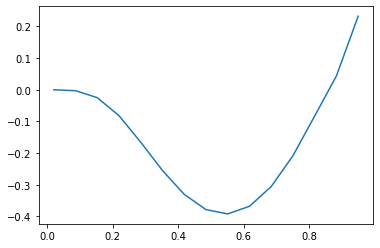

In [46]:
plt.plot(res["sigma_e"],res["mse"])